In [ ]:
import zipfile
import requests
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.6/877.6 kB 12.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def yolo2bbox(bboxes):
    # Преобразование координат ограничивающих рамок из формата YOLO в xmin, ymin, xmax, ymax
    xmin, ymin = bboxes[0] - bboxes[2] / 2, bboxes[1] - bboxes[3] / 2
    xmax, ymax = bboxes[0] + bboxes[2] / 2, bboxes[1] + bboxes[3] / 2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Необходимы высота и ширина изображения для денормализации координат ограничивающих рамок
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Денормализация координат
        xmin = int(x1 * w)
        ymin = int(y1 * h)
        xmax = int(x2 * w)
        ymax = int(y2 * h)

        thickness = max(2, int(w / 275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [ ]:
def plot(image_paths, label_paths, num_samples):
    # Список для хранения всех изображений
    all_images = []
    all_images.extend(glob.glob(image_paths + '/*.jpg'))
    all_images.extend(glob.glob(image_paths + '/*.JPG'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0, num_images - 1)  # Случайный выбор изображения
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])  # Извлечение имени файла без расширения
        image = cv2.imread(all_images[j])  # Чтение изображения
        with open(os.path.join(label_paths, image_name + '.txt'), 'r') as f:
            bboxes = []  # Список для ограничивающих рамок
            labels = []  # Список для меток
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]  # Извлечение метки
                bbox_string = label_line[2:]  # Извлечение строки ограничивающей рамки
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])  # Добавление ограничивающей рамки
                labels.append(label)  # Добавление метки
        result_image = plot_box(image, bboxes, labels)  # Отображение ограничивающих рамок на изображении
        plt.subplot(2, 2, i + 1)  # Расположение изображения в сетке
        plt.imshow(result_image[:, :, ::-1])  # Отображение изображения
        plt.axis('off')  # Отключение осей
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()  # Отображение графика

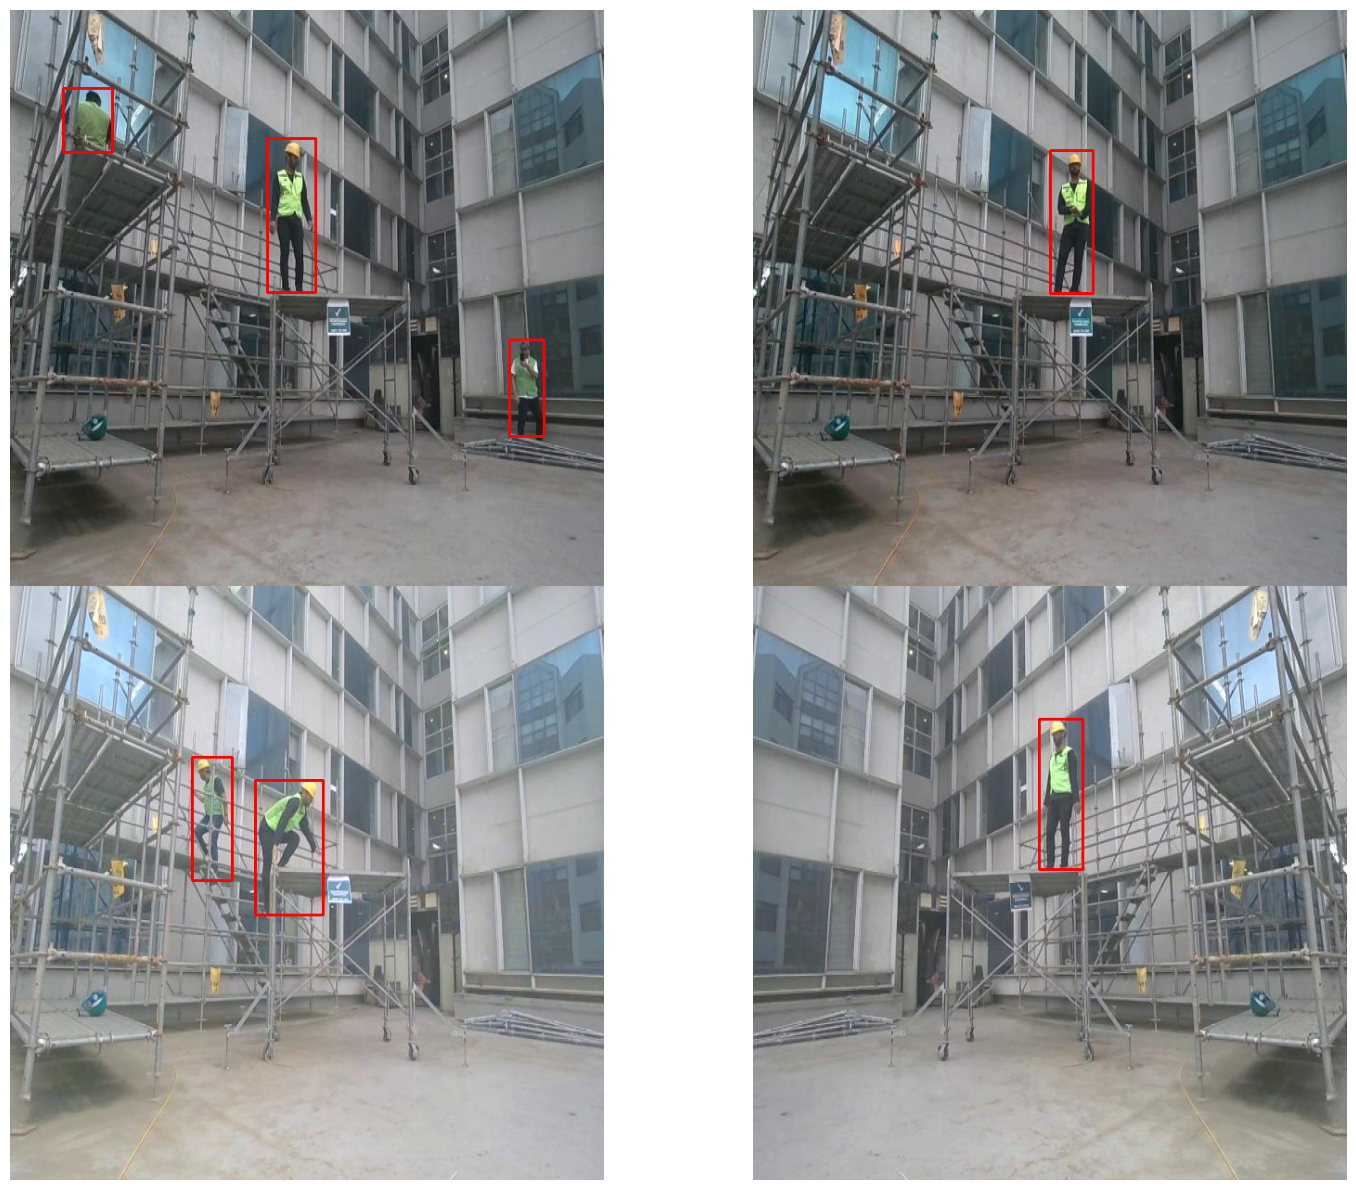

In [ ]:
# Визуализируем несколько тренировочных изображений.
plot(
    image_paths='/content/drive/MyDrive/workers_data/training/images/train',  # Путь к изображениям
    label_paths='/content/drive/MyDrive/workers_data/training/labels/train',  # Путь к меткам
    num_samples=4,  # Количество изображений для отображения
)

In [ ]:
# Обучение модели на 20 эпохах.
EPOCHS = 20
!yolo task=detect mode=train model=yolov8n.pt imgsz=640 data=/content/drive/MyDrive/workers_data/training/data.yaml epochs={EPOCHS} batch=16 name=yolov8n_v8_50e

Ultralytics 8.3.23 🚀 Python-3.10.12 torch-2.5.0+cpu CPU (Intel Xeon 2.00GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/workers_data/training/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_v8_50e2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels

In [ ]:
from google.colab import files
# Указываем путь к файлу best.pt
files.download('/content/runs/detect/yolov8n_v8_50e2/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!yolo task=detect mode=val model=/content/runs/detect/yolov8n_v8_50e2/weights/best.pt name=yolov8n_eval data=/content/drive/MyDrive/workers_data/training/data.yaml

Ultralytics 8.3.23 🚀 Python-3.10.12 torch-2.5.0+cpu CPU (Intel Xeon 2.00GHz)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/drive/MyDrive/workers_data/training/labels/valid.cache... 83 images, 0 backgrounds, 0 corrupt: 100% 83/83 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 6/6 [00:04<00:00,  1.30it/s]
                   all         83        102      0.956      0.928       0.99      0.749
 worker_without_helmet         73         82      0.912      0.976       0.99      0.795
    worker_with_helmet         18         20          1      0.881       0.99      0.703
Speed: 1.4ms preprocess, 37.5ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/yolov8n_eval
💡 Learn more at https://docs.ultralytics.com/modes/val


In [ ]:
!yolo task=detect \  # Задача: детекция объектов
mode=predict \  # Режим выполнения: предсказание на новых данных
model=/content/runs/detect/yolov8n_v8_50e2/weights/best.pt \  # Путь к файлу весов модели
source=/content/drive/MyDrive/workers_data/training/images/valid \  # Путь к директории с изображениями для предсказания
imgsz=640 \  # Размер изображений для предсказания (640x640 пикселей)
name=yolov8n_v8_50e2_infer640 \  # Имя для сохранения результатов предсказания
show_labels=True  # Отображать метки объектов на изображениях


Ultralytics 8.3.23 🚀 Python-3.10.12 torch-2.5.0+cpu CPU (Intel Xeon 2.00GHz)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs

image 1/83 /content/drive/MyDrive/workers_data/training/images/valid/20231005_165956_392_jpg.rf.04e807f7d5ee68eb5b81a765e41ccfdf.jpg: 640x640 5 worker_without_helmets, 68.3ms
image 2/83 /content/drive/MyDrive/workers_data/training/images/valid/20240527_175722_087_jpg.rf.178f9b561026dbf8373c07eb761fd711.jpg: 640x640 1 worker_without_helmet, 48.2ms
image 3/83 /content/drive/MyDrive/workers_data/training/images/valid/20240527_175722_087_jpg.rf.e153fff48cd78e29a24b12169b15a9a7.jpg: 640x640 1 worker_without_helmet, 47.6ms
image 4/83 /content/drive/MyDrive/workers_data/training/images/valid/20240527_175722_1041_jpg.rf.dc0a55a454c45feca948cba6549a6bbf.jpg: 640x640 1 worker_without_helmet, 46.5ms
image 5/83 /content/drive/MyDrive/workers_data/training/images/valid/20240527_175722_1455_jpg.rf.a0d7d471a9f1427910b82b47677300e4.jpg: 640x640 

In [ ]:
# Функция для отображения изображений в сетке 2x2
def visualize(result_dir, num_samples=4):
    """
    Функция принимает путь к директории с изображениями и отображает
    их в сетке 2x2.
    """
    plt.figure(figsize=(20, 12))  # Установка размера графика
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))  # Получение списка всех jpg изображений в директории
    random.shuffle(image_names)  # Перемешивание списка изображений
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)  # Чтение изображения
        plt.subplot(2, 2, i+1)  # Установка позиции для изображения в сетке
        plt.imshow(image)  # Отображение изображения
        plt.axis('off')  # Отключение осей
        if i == num_samples - 1:  # Если отображено нужное количество изображений
            break
    plt.tight_layout()  # Автоматическая подстройка подложки
    plt.show()  # Отображение графика


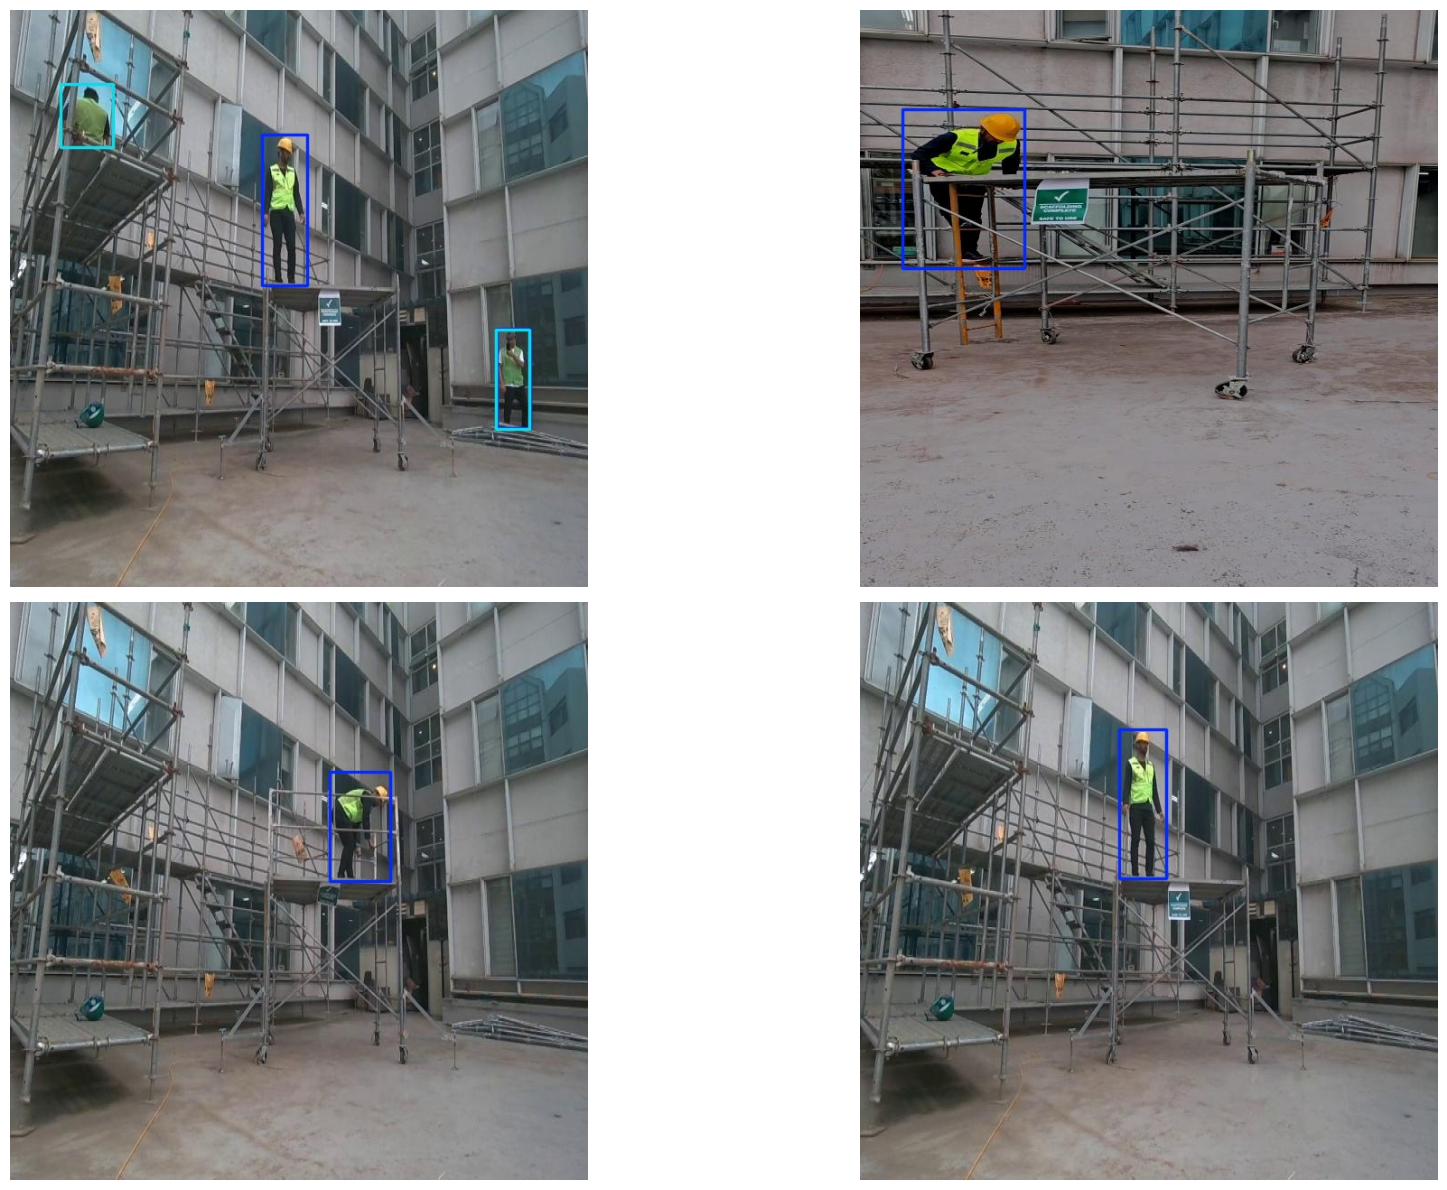

In [ ]:
visualize('runs/detect/yolov8n_v8_50e2_infer640')

In [29]:
import os

def prediction(model_path, source_path, img_size=640, name="yolov8n_infer", hide_labels=True):
    """
    Функция для выполнения предсказания с использованием модели YOLOv8.

    :param model_path: Путь к файлу модели (.pt).
    :param source_path: Путь к директории с изображениями для предсказания.
    :param img_size: Размер изображений для обработки (по умолчанию 640).
    :param name: Имя для сохранения результатов.
    :param hide_labels: Скрывать ли метки на предсказанных изображениях.
    """

    # Формируем команду для выполнения предсказания
    command = f"!yolo task=detect mode=predict model={model_path} source={source_path} imgsz={img_size} name={name} hide_labels={hide_labels}"

    # Выполнение команды
    os.system(command)

In [ ]:
capture = cv2.VideoCapture('/content/20241022112854361_b4fea72a54e944b0a747f235d2757196_AC1418956.mp4')

In [30]:
import cv2
import os

def process_video(video_path, img_size=640):
    """
    Функция для разбивки видео на фреймы и вызова функции предсказания.

    :param video_path: Путь к видеофайлу .mp4.
    :param img_size: Размер изображений для обработки (по умолчанию 640x640).
    """
    # Получаем имя видео без расширения
    video_name = os.path.splitext(os.path.basename(video_path))[0]

    # Папка для фреймов
    frames_dir = f"{video_name}_frames"

    # Создаем папку для сохранения фреймов
    if not os.path.exists(frames_dir):
        os.makedirs(frames_dir)

    # Открываем видеофайл с помощью OpenCV
    cap = cv2.VideoCapture(video_path)

    # Проверяем, что видео открылось корректно
    if not cap.isOpened():
        print(f"Ошибка открытия видео {video_path}")
        return

    frame_count = 0
    while True:
        # Читаем кадр за кадром
        ret, frame = cap.read()
        if not ret:
            break

        # Изменяем размер фрейма на 640x640
        resized_frame = cv2.resize(frame, (img_size, img_size))

        # Путь для сохранения каждого фрейма
        frame_path = os.path.join(frames_dir, f"frame_{frame_count:05d}.jpg")

        # Сохраняем фрейм
        cv2.imwrite(frame_path, resized_frame)
        frame_count += 1

    # Закрываем видеофайл
    cap.release()

    print(f"Видео разбито на {frame_count} фреймов и сохранено в {frames_dir}")

    # Вызываем функцию предсказания


# Пример использования
process_video('/content/20241022112854361_b4fea72a54e944b0a747f235d2757196_AC1418956.mp4', img_size=640)


Видео разбито на 3174 фреймов и сохранено в 20241022112854361_b4fea72a54e944b0a747f235d2757196_AC1418956_frames


In [31]:
import os
import glob
import random
import matplotlib.pyplot as plt

def visualize(result_dir, num_samples=4):
    """
    Функция для отображения изображений в сетке 2x2.

    :param result_dir: Путь к директории с изображениями предсказаний.
    :param num_samples: Количество случайных изображений для отображения (по умолчанию 4).
    """
    # Получаем список всех .jpg изображений в указанной директории
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))

    # Проверяем, достаточно ли изображений для выбора
    if len(image_names) < num_samples:
        print(f"В папке недостаточно изображений для отображения. Всего: {len(image_names)}")
        num_samples = len(image_names)

    # Перемешиваем изображения
    random.shuffle(image_names)

    # Создаем график
    plt.figure(figsize=(10, 10))

    # Проходим по выбранным изображениям
    for i, image_name in enumerate(image_names[:num_samples]):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i + 1)  # 2x2 сетка
        plt.imshow(image)
        plt.axis('off')  # Отключаем оси
        plt.title(f"Image {i + 1}")  # Название изображения

    plt.tight_layout()
    plt.show()

# Пример использования функции
visualize('/content/yolov8n_v8_50e2_infer640', num_samples=4)


В папке недостаточно изображений для отображения. Всего: 0


<Figure size 1000x1000 with 0 Axes>

In [32]:
!yolo task=detect \
mode=predict \
model=/content/runs/detect/yolov8n_v8_50e2/weights/best.pt \
source=/content/20241022112854361_b4fea72a54e944b0a747f235d2757196_AC1418956_frames \
imgsz=640 \
name=predicted_frames \
show_labels=True

Ultralytics 8.3.23 🚀 Python-3.10.12 torch-2.5.0+cpu CPU (Intel Xeon 2.00GHz)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs

image 1/3174 /content/20241022112854361_b4fea72a54e944b0a747f235d2757196_AC1418956_frames/frame_00000.jpg: 640x640 (no detections), 87.6ms
image 2/3174 /content/20241022112854361_b4fea72a54e944b0a747f235d2757196_AC1418956_frames/frame_00001.jpg: 640x640 (no detections), 57.1ms
image 3/3174 /content/20241022112854361_b4fea72a54e944b0a747f235d2757196_AC1418956_frames/frame_00002.jpg: 640x640 (no detections), 49.0ms
image 4/3174 /content/20241022112854361_b4fea72a54e944b0a747f235d2757196_AC1418956_frames/frame_00003.jpg: 640x640 (no detections), 48.5ms
image 5/3174 /content/20241022112854361_b4fea72a54e944b0a747f235d2757196_AC1418956_frames/frame_00004.jpg: 640x640 (no detections), 55.4ms
image 6/3174 /content/20241022112854361_b4fea72a54e944b0a747f235d2757196_AC1418956_frames/frame_00005.jpg: 640x640 (no detections), 53.7ms
image 7

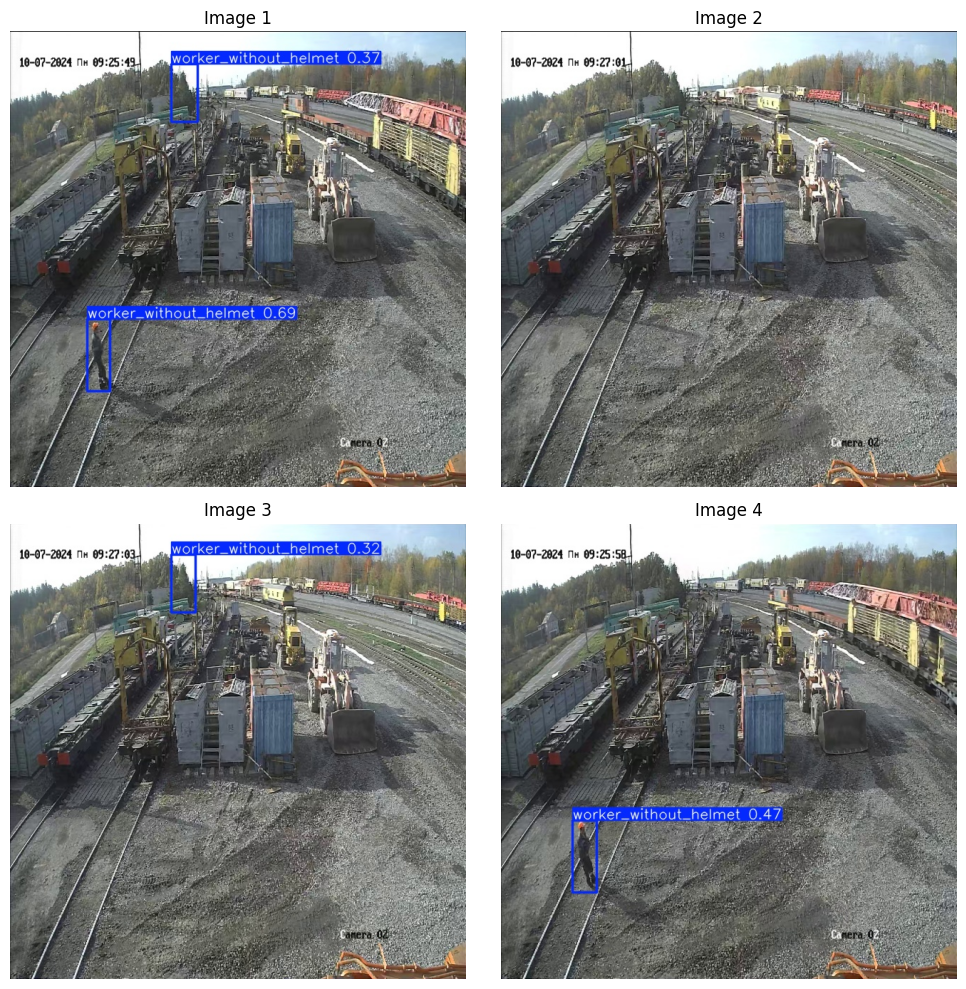

In [35]:
visualize('runs/detect/predicted_frames')